In [19]:
import os
import pandas as pd

# Path to label files
label_path = "labels/labels_native"

# Initialize data storage
data = []

# Iterate through label files
for file in os.listdir(label_path):
    if file.endswith(".txt"):
        with open(os.path.join(label_path, file), 'r') as f:
            for line in f:
                category, x_center, y_center, x_width, y_width = map(float, line.strip().split())
                data.append([file, category, x_center, y_center, x_width, y_width])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["file", "category", "x_center", "y_center", "x_width", "y_width"])


In [20]:
len(df)

29625

In [21]:
df.head()

,file,category,x_center,y_center,x_width,y_width
0,solarpanels_native_1__x0_8656_y0_10598_dxdy_41...,0.0,0.241587,0.063702,0.209135,0.079327
1,solarpanels_native_1__x0_8656_y0_10598_dxdy_41...,0.0,0.043269,0.092548,0.086538,0.064904
2,solarpanels_native_1__x0_8656_y0_10598_dxdy_41...,0.0,0.024038,0.318510,0.048077,0.055288
3,solarpanels_native_1__x0_8656_y0_10598_dxdy_41...,0.0,0.104567,0.588942,0.209135,0.100962
4,solarpanels_native_1__x0_8656_y0_10598_dxdy_41...,0.0,0.530048,0.518029,0.141827,0.045673


In [22]:
labels_per_image = df.groupby("file").size()
print(labels_per_image.value_counts())

3     221
4     218
5     217
6     189
8     184
     ... 
55      1
64      1
61      1
56      1
22      1
Name: count, Length: 74, dtype: int64


In [23]:
resolution = 0.31  # meters per pixel

# Calculate width and height in meters
df['width_m'] = df['x_width'] * 416 * resolution
df['height_m'] = df['y_width'] * 416 * resolution

# Calculate area in square meters
df['area_m2'] = df['width_m'] * df['height_m']

In [24]:
mean_area = df['area_m2'].mean()
std_area = df['area_m2'].std()

print(f"Mean area: {mean_area:.2f} square meters")
print(f"Standard deviation: {std_area:.2f} square meters")

Mean area: 191.52 square meters
Standard deviation: 630.71 square meters


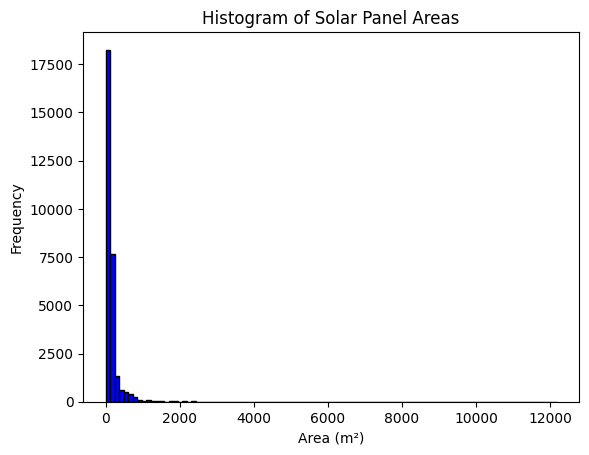

In [25]:
import matplotlib.pyplot as plt

plt.hist(df['area_m2'], bins=100, color='blue', edgecolor='black')
plt.title("Histogram of Solar Panel Areas")
plt.xlabel("Area (m²)")
plt.ylabel("Frequency")
plt.show()

In [26]:
from shapely.geometry import box as shapely_box
import numpy as np
import supervision as sv

def yolo_to_shapely_bbox(yolo_bbox):
    """Convert YOLO format [x_center, y_center, w, h] to Shapely box coordinates"""
    xc, yc, w, h = yolo_bbox
    return shapely_box(
        xc - w/2,  # x_min
        yc - h/2,  # y_min
        xc + w/2,  # x_max
        yc + h/2   # y_max
    )

def iou_shapely(yolo_bbox1, yolo_bbox2):
    """Compute IoU for YOLO-format boxes using Shapely"""
    box1 = yolo_to_shapely_bbox(yolo_bbox1)
    box2 = yolo_to_shapely_bbox(yolo_bbox2)
    
    intersection = box1.intersection(box2).area
    union = box1.area + box2.area - intersection
    return intersection / union if union > 0 else 0.0

# Test cases comparing with supervision library
test_cases = [
    ([50, 50, 20, 20], [50, 50, 20, 20]),   # Perfect match
    ([40, 40, 20, 20], [60, 60, 20, 20]),   # No overlap
    ([50, 50, 20, 20], [52, 52, 20, 20]),   # Partial overlap
    ([45, 45, 30, 30], [55, 55, 30, 30])    # Large overlap
]

for b1, b2 in test_cases:
    # Custom Shapely implementation
    custom_iou = iou_shapely(b1, b2)
    
    # Convert to XYXY format for supervision
    def yolo_to_xyxy(yolo_box):
        return np.array([
            [yolo_box[0]-yolo_box[2]/2, 
             yolo_box[1]-yolo_box[3]/2,
             yolo_box[0]+yolo_box[2]/2,
             yolo_box[1]+yolo_box[3]/2]
        ])
        
    # Compute supervision IoU
    sup_iou = sv.box_iou_batch(yolo_to_xyxy(b1), yolo_to_xyxy(b2))[0][0]
    print(f"Shapely: {custom_iou:.4f} | Supervision: {sup_iou:.4f}")


Shapely: 1.0000 | Supervision: 1.0000
Shapely: 0.0000 | Supervision: 0.0000
Shapely: 0.6807 | Supervision: 0.6807
Shapely: 0.2857 | Supervision: 0.2857


In [27]:
from collections import defaultdict

def compute_ap_voc(predictions, ground_truths, iou_threshold=0.5):
    """
    Compute Average Precision using Pascal VOC 11-point interpolation method
    
    Args:
        predictions: List of dicts with keys:
            'image_id': ID of corresponding image
            'box': YOLO format [x_center, y_center, width, height]
            'score': Confidence score
        ground_truths: Dict mapping image_id to list of YOLO format boxes
        iou_threshold: IoU threshold for considering TP/FP (default: 0.5)
    
    Returns:
        AP (float): Average Precision score
    """
    
    # Sort predictions by descending confidence
    predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)
    
    # Initialize tracking variables
    tp = []
    fp = []
    total_gt = sum(len(gts) for gts in ground_truths.values())
    matched_gts = defaultdict(set)

    # Process each prediction
    for pred in predictions:
        image_id = pred['image_id']
        pred_box = pred['box']
        best_iou = 0.0
        best_gt_idx = -1

        # Find best matching ground truth
        for gt_idx, gt_box in enumerate(ground_truths.get(image_id, [])):
            if gt_idx in matched_gts[image_id]:
                continue  # Already matched
            current_iou = iou_shapely(pred_box, gt_box)
            if current_iou > best_iou:
                best_iou = current_iou
                best_gt_idx = gt_idx

        # Determine TP/FP
        if best_iou >= iou_threshold:
            tp.append(1)
            fp.append(0)
            matched_gts[image_id].add(best_gt_idx)
        else:
            tp.append(0)
            fp.append(1)

    # Calculate cumulative TP/FP
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    # Compute precision and recall
    precision = cum_tp / (cum_tp + cum_fp + 1e-10)
    recall = cum_tp / (total_gt + 1e-10)

    # 11-point interpolation
    recall_levels = np.linspace(0, 1, 11)
    interpolated_precisions = []
    
    for r in recall_levels:
        # Get all precision values where recall >= current level
        valid_precisions = precision[recall >= r]
        interpolated_precisions.append(valid_precisions.max() if valid_precisions.size > 0 else 0)

    # Average precision across all recall levels
    ap = np.mean(interpolated_precisions)
    
    return ap

In [28]:
def compute_ap_coco(predictions, ground_truths, iou_threshold=0.5):
    """
    Compute Average Precision using COCO 101-point interpolation method
    
    Args:
        predictions: List of dicts with keys:
            'image_id': ID of corresponding image
            'box': YOLO format [x_center, y_center, width, height]
            'score': Confidence score
        ground_truths: Dict mapping image_id to list of YOLO format boxes
        iou_threshold: IoU threshold for considering TP/FP (default: 0.5)
    
    Returns:
        AP (float): Average Precision score
    """
    # Sort predictions by descending confidence
    predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)
    
    # Initialize tracking variables
    tp = []
    fp = []
    total_gt = sum(len(gts) for gts in ground_truths.values())
    matched_gts = defaultdict(set)

    # Process each prediction
    for pred in predictions:
        image_id = pred['image_id']
        pred_box = pred['box']
        best_iou = 0.0
        best_gt_idx = -1

        # Find best matching ground truth
        for gt_idx, gt_box in enumerate(ground_truths.get(image_id, [])):
            if gt_idx in matched_gts[image_id]:
                continue  # Already matched
            current_iou = iou_shapely(pred_box, gt_box)
            if current_iou > best_iou:
                best_iou = current_iou
                best_gt_idx = gt_idx

        # Determine TP/FP
        if best_iou >= iou_threshold:
            tp.append(1)
            fp.append(0)
            matched_gts[image_id].add(best_gt_idx)
        else:
            tp.append(0)
            fp.append(1)

    # Calculate cumulative TP/FP
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    # Compute precision and recall
    precision = cum_tp / (cum_tp + cum_fp + 1e-10)
    recall = cum_tp / (total_gt + 1e-10)

    # COCO 101-point interpolation
    recall_levels = np.linspace(0, 1, 101)
    interpolated_precisions = []
    
    for r in recall_levels:
        # Get all precision values where recall >= current level
        valid_precisions = precision[recall >= r]
        interpolated_precisions.append(valid_precisions.max() if valid_precisions.size > 0 else 0)

    # Average precision across all recall levels
    ap = np.mean(interpolated_precisions)
    
    return ap

In [29]:
import numpy as np
from collections import defaultdict

def compute_ap_auc(predictions, ground_truths, iou_threshold=0.5):
    """
    Compute Average Precision (AP) using Area Under Precision-Recall Curve (AUC-PR)
    
    Args:
        predictions: List of dicts with keys:
            'image_id': ID of corresponding image
            'box': YOLO format [x_center, y_center, width, height]
            'score': Confidence score
        ground_truths: Dict mapping image_id to list of YOLO format boxes
        iou_threshold: IoU threshold for considering TP/FP (default: 0.5)
    
    Returns:
        AP (float): Area Under Precision-Recall Curve
    """
    # Sort predictions by descending confidence
    predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)
    
    # Initialize tracking variables
    tp = []
    fp = []
    total_gt = sum(len(gts) for gts in ground_truths.values())
    matched_gts = defaultdict(set)

    # Process each prediction
    for pred in predictions:
        image_id = pred['image_id']
        pred_box = pred['box']
        best_iou = 0.0
        best_gt_idx = -1

        # Find best matching ground truth
        for gt_idx, gt_box in enumerate(ground_truths.get(image_id, [])):
            if gt_idx in matched_gts[image_id]:
                continue  # Already matched
            current_iou = iou_shapely(pred_box, gt_box)
            if current_iou > best_iou:
                best_iou = current_iou
                best_gt_idx = gt_idx

        # Determine TP/FP
        if best_iou >= iou_threshold:
            tp.append(1)
            fp.append(0)
            matched_gts[image_id].add(best_gt_idx)
        else:
            tp.append(0)
            fp.append(1)

    # Calculate cumulative TP/FP
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    # Compute precision and recall
    precision = cum_tp / (cum_tp + cum_fp + 1e-10)
    recall = cum_tp / (total_gt + 1e-10)

    # Add (0, 1) point for initial state
    precision = np.concatenate([[1.0], precision])
    recall = np.concatenate([[0.0], recall])

    # Compute AUC using trapezoidal rule
    # Sort indices by recall values to handle potential non-monotonicity
    sorted_indices = np.argsort(recall)
    sorted_recall = recall[sorted_indices]
    sorted_precision = precision[sorted_indices]
    
    # Calculate area under curve
    ap = np.trapz(sorted_precision, sorted_recall)
    
    return ap

In [30]:
import random

def generate_boxes(num_boxes, img_size=100, box_size=20):
    return [
        [
            random.uniform(box_size/2, img_size-box_size/2),
            random.uniform(box_size/2, img_size-box_size/2),
            box_size, box_size
        ] for _ in range(num_boxes)
    ]

# Generate dataset
num_images = 10
ground_truths = {i: generate_boxes(10) for i in range(num_images)}
predictions = [
    {
        'image_id': i,
        'box': generate_boxes(1)[0],
        'score': random.random()
    } 
    for i in range(num_images) for _ in range(10)
]

In [31]:
print(f"{'Method':<30} | AP50")
print("-" * 35)
print(f"{'Pascal VOC 11-point':<30} | {compute_ap_voc(predictions, ground_truths):.4f}")
print(f"{'COCO 101-point':<30} | {compute_ap_coco(predictions, ground_truths):.4f}")
print(f"{'AUC Trapezoidal':<30} | {compute_ap_auc(predictions, ground_truths):.4f}")

Method                         | AP50
-----------------------------------
Pascal VOC 11-point            | 0.0567
COCO 101-point                 | 0.0326
AUC Trapezoidal                | 0.0251


In [32]:
from sklearn.model_selection import train_test_split

unique_files = df['file'].unique()

# First, split into train (80%) and test (20%)
train_val_files, test_files = train_test_split(unique_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_val_files, test_size=0.1, random_state=42)

# Print the number of unique images in each split
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

Training images: 1829
Validation images: 204
Test images: 509


In [17]:
import os
import shutil
# ---------------------------
base_dir = 'data'

# Directories for images
train_img_dir = os.path.join(base_dir, 'images/train')
val_img_dir = os.path.join(base_dir, 'images/val')
test_img_dir = os.path.join(base_dir, 'images/test')

# Directories for labels
train_label_dir = os.path.join(base_dir, 'labels/train')
val_label_dir = os.path.join(base_dir, 'labels/val')
test_label_dir = os.path.join(base_dir, 'labels/test')

# Create directories if they don't exist
for d in [train_img_dir, val_img_dir, test_img_dir, train_label_dir, val_label_dir, test_label_dir]:
    os.makedirs(d, exist_ok=True)

# ---------------------------
# 3. Copy Files to New Directories
# ---------------------------
def copy_files(file_list, src_dir, dest_dir):
    """
    Copy files (e.g., label files) with the same filename.
    """
    for file_name in file_list:
        src_file = os.path.join(src_dir, file_name)
        dst_file = os.path.join(dest_dir, file_name)
        if os.path.exists(src_file):
            shutil.copy(src_file, dst_file)
        else:
            print(f"Warning: File {src_file} does not exist.")

def copy_images(file_list, src_dir, dest_dir):
    """
    Copy image files by converting label filenames (ending with .txt) to image filenames (ending with .tif).
    Assumes that if a label file is named "foo.txt", the corresponding image is "foo.tif".
    """
    for file_name in file_list:
        # Remove the .txt extension and add .tif extension
        base_name = os.path.splitext(file_name)
        image_filename = base_name[0] + ".tif"
        src_image = os.path.join(src_dir, image_filename)
        dst_image = os.path.join(dest_dir, image_filename)
        if os.path.exists(src_image):
            shutil.copy(src_image, dst_image)
        else:
            print(f"Warning: File {src_image} does not exist.")
# Paths for original images
original_image_dir = 'image_chips_native/'  # Update this to your actual images folder

# Copy label files (from your original labels folder)
copy_files(train_files, label_path, train_label_dir)
copy_files(val_files, label_path, val_label_dir)
copy_files(test_files, label_path, test_label_dir)

# Copy image files (filenames extracted from labels should match the image filenames, except extension)
copy_images(train_files, original_image_dir, train_img_dir)
copy_images(val_files, original_image_dir, val_img_dir)
copy_images(test_files, original_image_dir, test_img_dir)

print("Splitting and copying of files is complete.")

Splitting and copying of files is complete.


In [33]:
import os

def fix_labels(label_dir):
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(label_dir, split)
        if not os.path.exists(split_dir):
            continue
        for label_file in os.listdir(split_dir):
            if not label_file.endswith('.txt'):
                continue
            file_path = os.path.join(split_dir, label_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
            corrected = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    parts[0] = '0'  # Force class ID to 0
                    corrected.append(' '.join(parts))
            # Overwrite the file
            with open(file_path, 'w') as f:
                f.write('\n'.join(corrected))

# Replace with your actual labels directory
label_dir = '/home/amit/srip/data/labels'
fix_labels(label_dir)

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the YOLOv8 model (pretrained on COCO)
model = YOLO("yolov8s.pt")  # Small model for efficient training

# Train the model
results = model.train(
    data="solar_panels.yaml",  # Path to your dataset YAML file
    epochs=50,
    imgsz=640,
    batch=16,
    name="solar_panel_detection",
    project="solar_panel_project",
    val=True  # Ensure validation is enabled
)


Ultralytics 8.3.77 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5797MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=solar_panels.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=solar_panel_project, name=solar_panel_detection5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

train: Scanning /home/amit/srip/data/labels/train.cache... 1829 images, 0 backgr
val: Scanning /home/amit/srip/data/labels/val.cache... 204 images, 0 backgrounds


Plotting labels to solar_panel_project/solar_panel_detection5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to solar_panel_project/solar_panel_detection5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.78G      1.498      1.559       1.26         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.776      0.771      0.821      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.84G      1.276     0.9152      1.132         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.788      0.752      0.783      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.92G      1.269     0.8472       1.13        100        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.817      0.787      0.858      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.79G      1.217     0.7937      1.101         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.863      0.824      0.898      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.51G      1.174     0.7578      1.085         95        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.861       0.84      0.916      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.54G      1.146      0.731      1.076         92        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.858      0.812      0.889      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.54G      1.119     0.6898       1.07         92        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146       0.87      0.833      0.891       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.61G       1.08     0.6585      1.041         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.893      0.854      0.933      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.7G      1.086     0.6561      1.041         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.907      0.899      0.944      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.45G      1.042     0.6336      1.021         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.896      0.884      0.926      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.96G      1.017     0.6134      1.019         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.877      0.906      0.942      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.87G          1      0.605      1.017         79        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146       0.92      0.905      0.954      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.56G     0.9848     0.5854      1.002        103        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.908      0.901      0.942      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.62G     0.9825     0.5783      1.003         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.914      0.903      0.954      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.72G     0.9634      0.569     0.9921         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.932      0.929      0.963      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.46G     0.9266     0.5478       0.98         99        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.944      0.922      0.968      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.25G     0.9224     0.5373     0.9728         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.935      0.922      0.961      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.68G     0.8921     0.5311     0.9705         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.956      0.933      0.974      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.48G     0.8929     0.5263     0.9626        135        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.946      0.939      0.973      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.37G      0.869     0.5141     0.9615         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.955       0.93      0.975      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.3G     0.8482     0.5062     0.9505         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146       0.95      0.932      0.976      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.15G     0.8438     0.4981     0.9488         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.957      0.941      0.978      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.07G     0.8363     0.4907     0.9423         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.963      0.952      0.981      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         4G     0.8272     0.4898     0.9429         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.968      0.941      0.983      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.27G     0.7983      0.476     0.9341         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.958      0.954      0.983      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.14G     0.7751     0.4634     0.9304         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.961      0.952      0.982      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.41G     0.7814     0.4642     0.9269        117        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.951      0.952      0.979      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.84G     0.7816     0.4626     0.9275         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.951      0.941       0.98      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.13G     0.7634     0.4539     0.9255         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.956      0.951      0.982      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.52G      0.748     0.4434     0.9147        100        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.969      0.961      0.988      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.5G      0.737     0.4392     0.9146         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.973      0.957      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.38G     0.7077     0.4254     0.9058         85        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.977      0.959      0.987      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.15G     0.6961     0.4177     0.9014        104        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146       0.98      0.954      0.988       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.45G     0.7019     0.4241     0.9045        146        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.968      0.962      0.986       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.02G     0.6861     0.4135     0.9001         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146       0.98      0.963      0.989      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.32G     0.6894     0.4119     0.8979        115        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.972      0.962      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.33G     0.6761     0.4113     0.8992         90        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146       0.97      0.972       0.99       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.59G     0.6535     0.4007      0.892         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.977      0.964       0.99      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.24G     0.6517     0.3993     0.8911        143        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.972       0.97      0.989      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       4.1G     0.6273     0.3849     0.8797        139        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.968      0.977      0.989      0.861


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         4G     0.5975     0.3599     0.8678         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.977      0.973      0.989      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.97G     0.5711     0.3454     0.8605         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.979      0.973      0.991      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.87G     0.5605     0.3409     0.8555         95        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.982      0.967       0.99      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.14G     0.5411     0.3332     0.8524        119        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.982      0.971       0.99      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.02G     0.5298     0.3301     0.8505         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.979      0.978      0.991      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.06G     0.5154     0.3238     0.8436         82        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.982      0.975      0.991      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.07G     0.5106      0.319     0.8468         93        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.984      0.973      0.991      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.09G     0.4937     0.3146     0.8454         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.981      0.977      0.991      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.82G     0.4952     0.3123     0.8397         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.984      0.979      0.992      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.91G     0.4746     0.3042     0.8362         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        204       2146      0.982      0.978      0.991      0.897



50 epochs completed in 0.609 hours.
Optimizer stripped from solar_panel_project/solar_panel_detection5/weights/last.pt, 22.5MB
Optimizer stripped from solar_panel_project/solar_panel_detection5/weights/best.pt, 22.5MB

Validating solar_panel_project/solar_panel_detection5/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5797MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        204       2146      0.982      0.978      0.991      0.897
Speed: 0.5ms preprocess, 6.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to solar_panel_project/solar_panel_detection5


AttributeError: 'DetMetrics' object has no attribute 'results'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

<Figure size 1000x600 with 0 Axes>

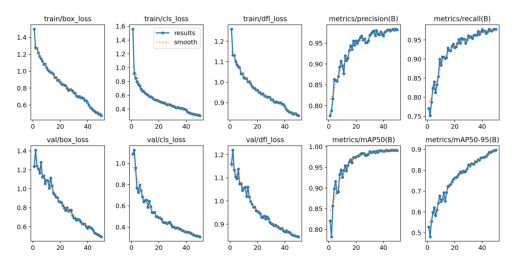

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('solar_panel_project/solar_panel_detection5/results.png')

# Display the image
plt.imshow(image)
plt.axis('off') 
plt.show()


image 1/1 /home/amit/srip/data/images/test/solarpanels_native_2__x0_0_y0_11689_dxdy_416.tif: 640x640 29 solar_panels, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


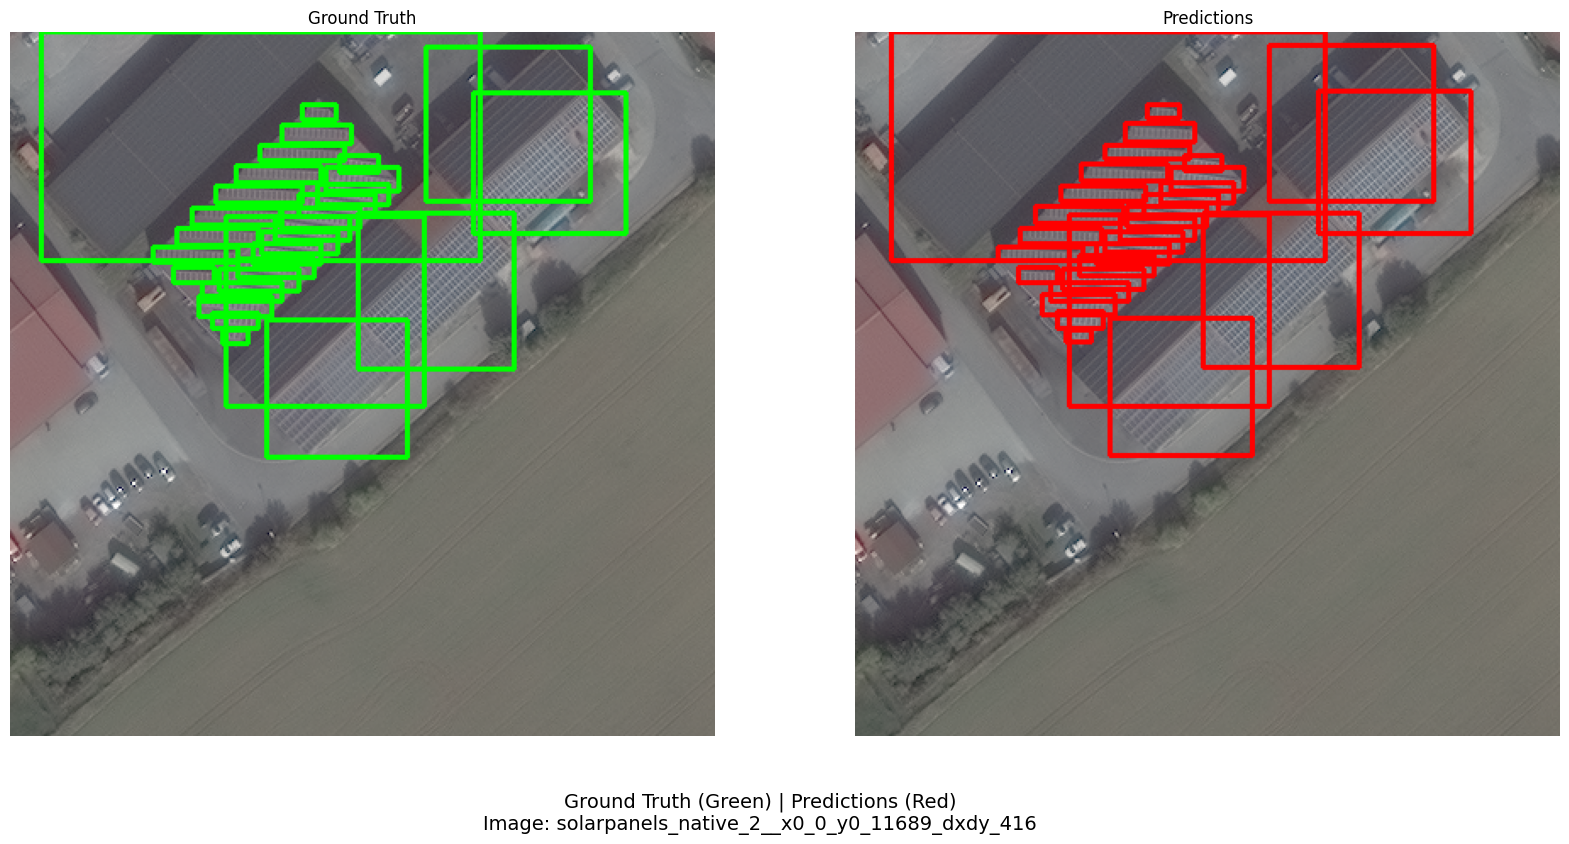


image 1/1 /home/amit/srip/data/images/test/solarpanels_native_3__x0_4328_y0_15272_dxdy_416.tif: 640x640 12 solar_panels, 14.6ms
Speed: 4.1ms preprocess, 14.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


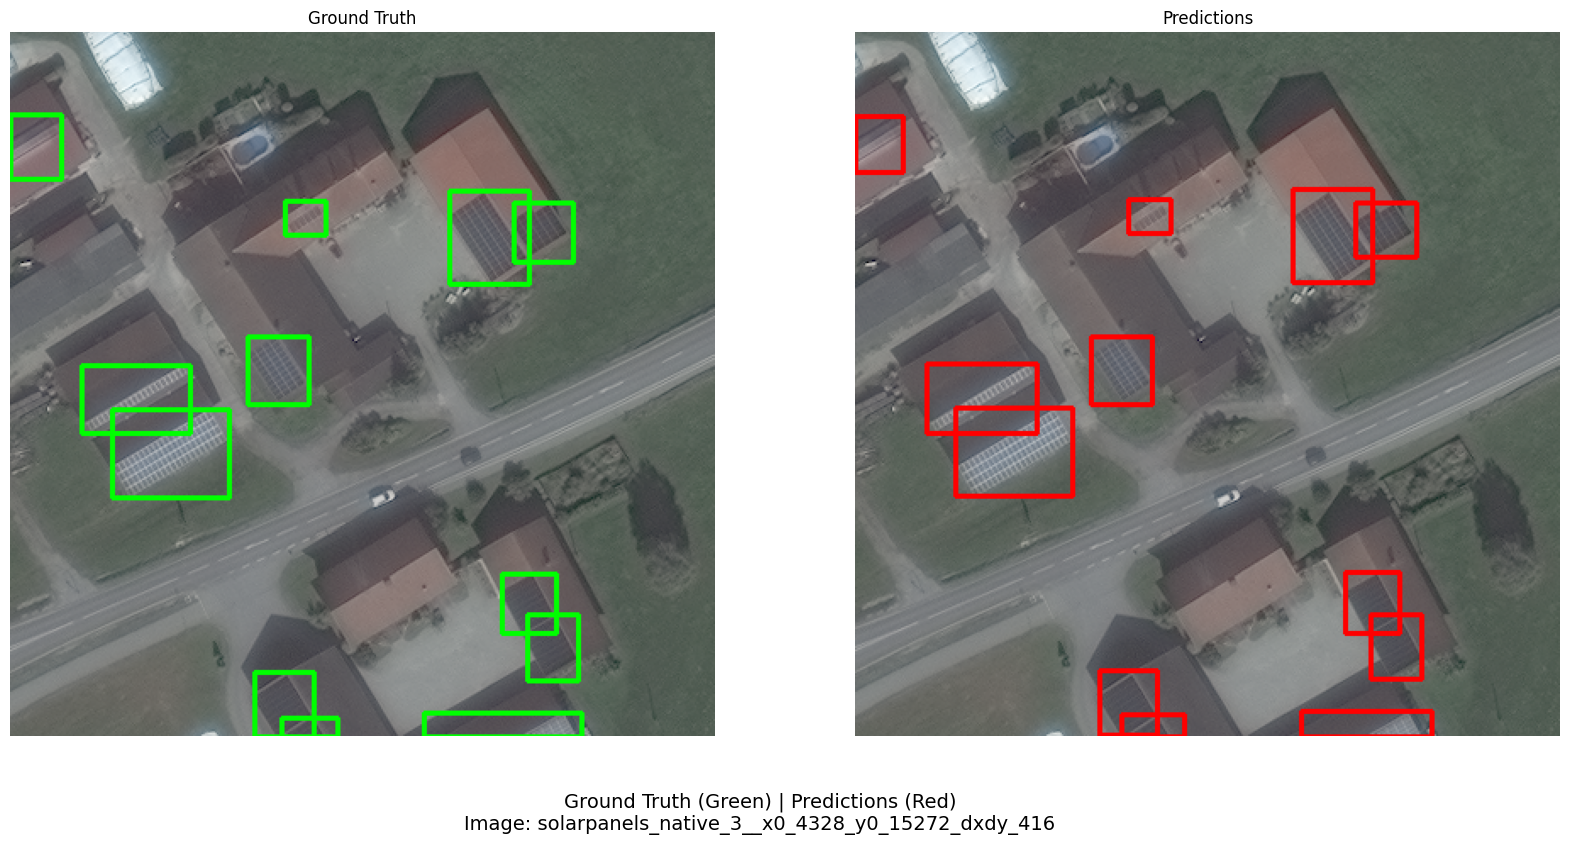


image 1/1 /home/amit/srip/data/images/test/solarpanels_native_2__x0_6273_y0_2640_dxdy_416.tif: 640x640 7 solar_panels, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


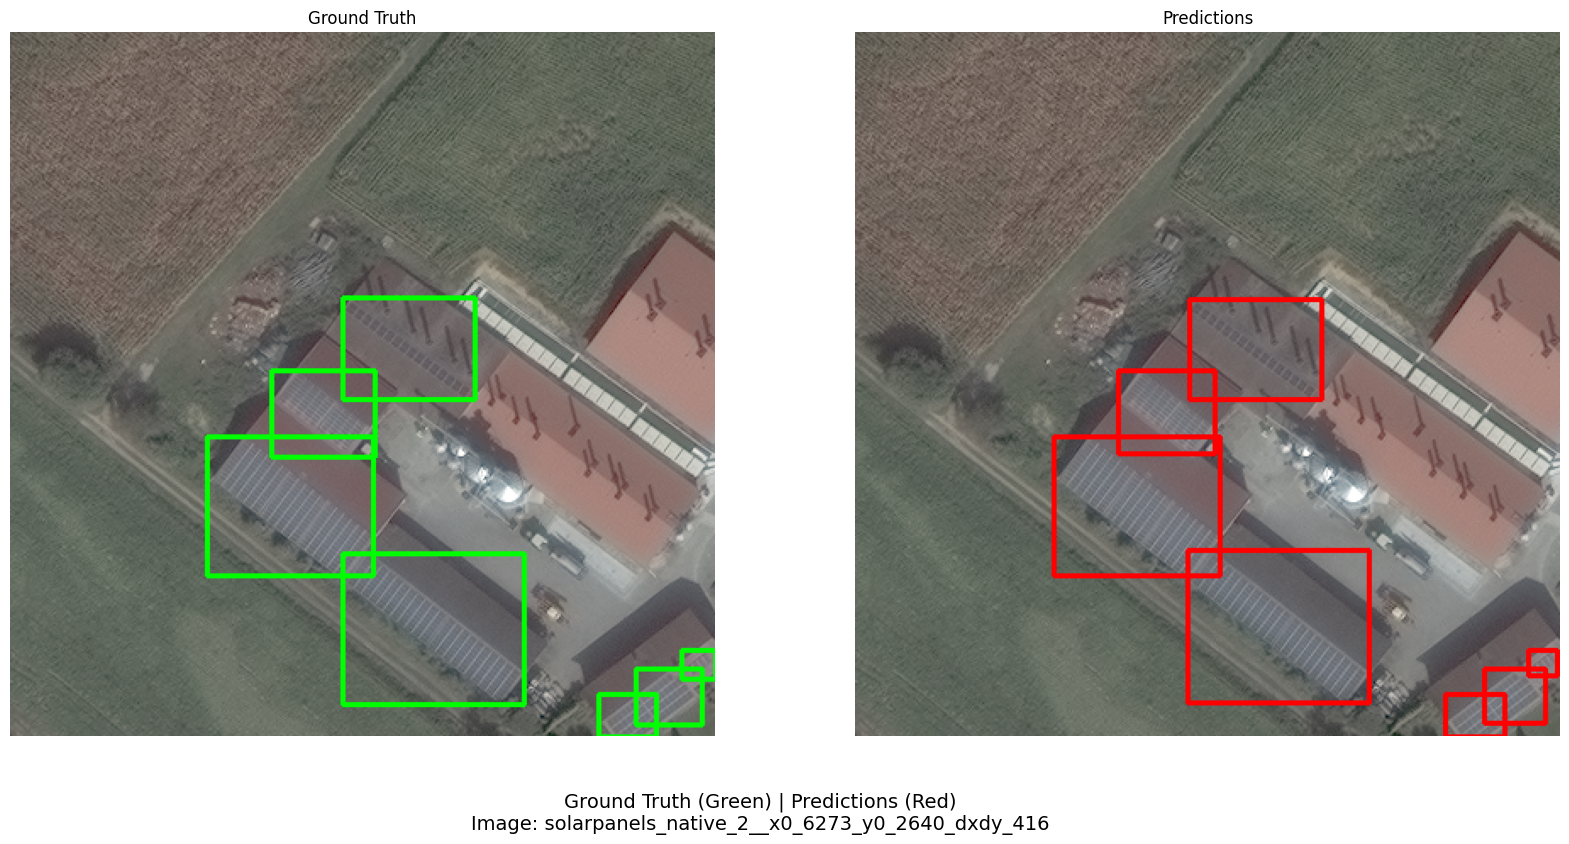

In [27]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO('solar_panel_project/solar_panel_detection5/weights/best.pt')  # Path to your trained weights

# Path configuration
test_image_dir = 'data/images/test'
test_label_dir = 'data/labels/test'

# Get random test samples
all_test_images = [f for f in os.listdir(test_image_dir) if f.endswith(('.tif'))]
selected_images = random.sample(all_test_images, 3)

# Visualization settings
gt_color = (0, 255, 0)  # Green for ground truth
pred_color = (255, 0, 0)  # Red for predictions
line_thickness = 2

def plot_comparison(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Get predictions
    results = model.predict(image_path, conf=0.5)
    
    # Load ground truth
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(test_label_dir, base_name + '.txt')
    
    # Create copies for visualization
    gt_image = image.copy()
    pred_image = image.copy()
    
    # Plot ground truth
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, xc, yc, bw, bh = map(float, line.strip().split())
                
                # Convert YOLO format to pixel coordinates
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                
                cv2.rectangle(gt_image, (x1, y1), (x2, y2), gt_color, line_thickness)
    
    # Plot predictions
    for box in results[0].boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(pred_image, (x1, y1), (x2, y2), pred_color, line_thickness)
    
    # Create comparison plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(gt_image)
    ax[0].set_title('Ground Truth', fontsize=12)
    ax[0].axis('off')
    
    ax[1].imshow(pred_image)
    ax[1].set_title('Predictions', fontsize=12)
    ax[1].axis('off')
    
    # Create legend
    plt.figtext(0.5, 0.05, 
                f"Ground Truth (Green) | Predictions (Red)\nImage: {base_name}",
                ha='center', fontsize=14)
    
    plt.show()

# Generate visualizations
for img_name in selected_images:
    img_path = os.path.join(test_image_dir, img_name)
    plot_comparison(img_path)


In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np

model = YOLO('/home/amit/srip/solar_panel_project/solar_panel_detection5/weights/best.pt')
map_metric = sv.metrics.MeanAveragePrecision()

test_img_dir = "/home/amit/srip/data/images/test"
def yolo_to_xywhn(image, label_path):
    """Convert YOLO format labels to absolute coordinates"""
    h, w = image.shape[:2]
    boxes = []
    class_ids = []
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                boxes.append([x1, y1, x2, y2])
                class_ids.append(int(class_id))
    
    return sv.Detections(
        xyxy=np.array(boxes) if boxes else np.empty((0, 4)),
        class_id=np.array(class_ids, dtype=int)
    )

for img_name in os.listdir(test_img_dir):
    if not img_name.endswith(('.tif')):
        continue
    
    img_path = os.path.join(test_img_dir, img_name)
    image = cv2.imread(img_path)
    
    # Get predictions
    results = model(image)[0]
    predictions = sv.Detections.from_ultralytics(results)
    
    # Load annotations
    base_name = os.path.splitext(img_name)[0]
    label_path = os.path.join("/home/amit/srip/data/labels/test", f"{base_name}.txt")
    annotations = yolo_to_xywhn(image, label_path)
    
    map_metric.update(predictions=predictions, targets=annotations)

map_result = map_metric.compute()


In [15]:
print(f"mAP50: {map_result.map50:.3f}")

mAP50: 0.979


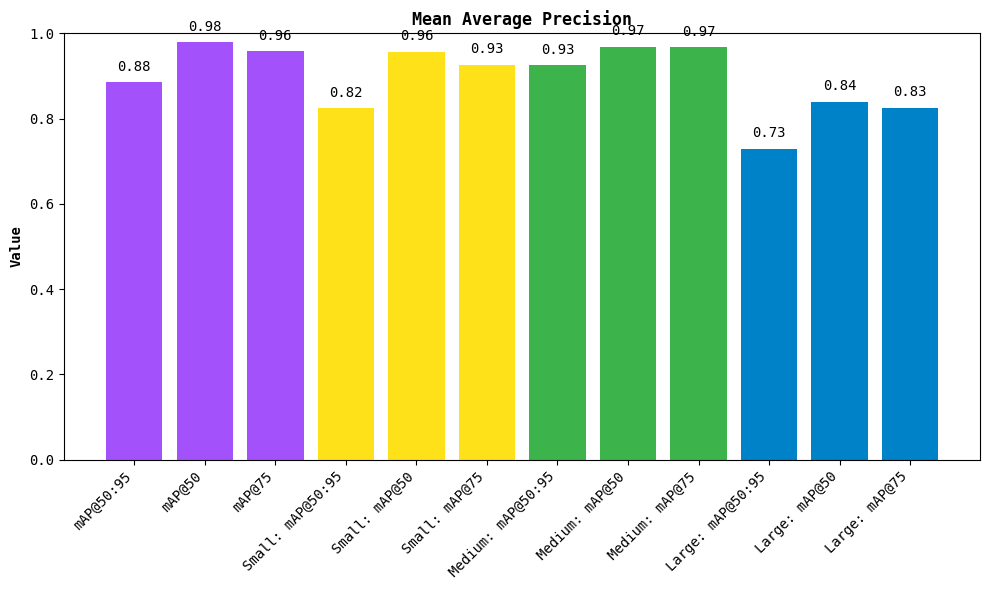

In [16]:
map_result.plot()

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import supervision as sv


# Initialize model and containers
model = YOLO('/home/amit/srip/solar_panel_project/solar_panel_detection5/weights/best.pt')
test_img_dir = "/home/amit/srip/data/images/test"
test_lbl_dir = "/home/amit/srip/data/labels/test"

# Data structures for both evaluation methods
custom_predictions = []
custom_ground_truths = defaultdict(list)
supervision_metric = sv.metrics.MeanAveragePrecision()

# Process each image
for img_name in os.listdir(test_img_dir):
    if not img_name.endswith('.tif'):
        continue
    
    img_path = os.path.join(test_img_dir, img_name)
    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    image_id = os.path.splitext(img_name)[0]  # Use filename as image ID

    # Get model predictions
    results = model(image)[0]
    predictions = sv.Detections.from_ultralytics(results)

    # Convert predictions to custom format
    for box, score in zip(predictions.xyxy, predictions.confidence):
        x_center = ((box[0] + box[2])/2) / w  # Convert to YOLO format
        y_center = ((box[1] + box[3])/2) / h
        width = (box[2] - box[0]) / w
        height = (box[3] - box[1]) / h
        
        custom_predictions.append({
            'image_id': image_id,
            'box': [x_center, y_center, width, height],
            'score': score
        })

    # Load and convert ground truth
    label_path = os.path.join(test_lbl_dir, f"{image_id}.txt")
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, xc, yc, bw, bh = map(float, line.strip().split())
                custom_ground_truths[image_id].append([xc, yc, bw, bh])
    
    # Convert to supervision format
    annotations = sv.Detections(
        xyxy=np.array([
            [(xc - bw/2)*w, (yc - bh/2)*h, (xc + bw/2)*w, (yc + bh/2)*h]
            for xc, yc, bw, bh in custom_ground_truths[image_id]
        ]) if custom_ground_truths[image_id] else np.empty((0, 4)),
        class_id=np.zeros(len(custom_ground_truths[image_id]), dtype=int)
    )
    
    # Update supervision metric
    supervision_metric.update(predictions=predictions, targets=annotations)

# Compute both metrics
voc_ap = compute_ap_voc(custom_predictions, custom_ground_truths)
coco_ap = compute_ap_coco(custom_predictions, custom_ground_truths)
auc_ap = compute_ap_auc(custom_predictions, custom_ground_truths)
supervision_result = supervision_metric.compute()

In [15]:
# Print comparison
print(f"\nComparison Results:")
print(f"Pascal VOC 11-point AP50: {voc_ap:.4f}")
print(f"COCO 101-point AP50: {coco_ap:.4f}")
print(f"AUC-PR AP50: {auc_ap:.4f}")
print(f"Supervision mAP50: {supervision_result.map50:.4f}")


Comparison Results:
Pascal VOC 11-point AP50: 0.9090
COCO 101-point AP50: 0.9797
AUC-PR AP50: 0.9839
Supervision mAP50: 0.9792


In [ ]:
import os
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO
import pandas as pd

model = YOLO('/home/amit/srip/solar_panel_project/solar_panel_detection5/weights/best.pt')

test_img_dir = "/home/amit/srip/data/images/test"
test_lbl_dir = "/home/amit/srip/data/labels/test"

ground_truths = []
all_predictions = []

def load_ground_truth(image, label_path):
    h, w = image.shape[:2]
    boxes = []
    class_ids = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id, xc, yc, bw, bh = map(float, parts)
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h
                boxes.append([x1, y1, x2, y2])
                class_ids.append(int(class_id))
    return sv.Detections(
        xyxy=np.array(boxes) if boxes else np.empty((0, 4)),
        class_id=np.array(class_ids, dtype=int)
    )

for img_name in os.listdir(test_img_dir):
    if not img_name.endswith('.tif'):
        continue
    
    img_path = os.path.join(test_img_dir, img_name)
    image = cv2.imread(img_path)
    
    # Get predictions
    results = model(image)[0]
    detections = sv.Detections.from_ultralytics(results)
    all_predictions.append(detections)
    
    # Load ground truth
    base_name = os.path.splitext(img_name)[0]
    label_path = os.path.join(test_lbl_dir, f"{base_name}.txt")
    gt_detections = load_ground_truth(image, label_path)
    ground_truths.append(gt_detections)

# Define thresholds
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Store results
results = []

for conf_thresh in confidence_thresholds:
    # Filter predictions by confidence threshold
    filtered_preds = []
    for pred in all_predictions:
        mask = pred.confidence >= conf_thresh
        filtered = sv.Detections(
            xyxy=pred.xyxy[mask],
            confidence=pred.confidence[mask],
            class_id=pred.class_id[mask]
        )
        filtered_preds.append(filtered)
    
    for iou_thresh in iou_thresholds:
        # Compute confusion matrix
        cm = sv.ConfusionMatrix.from_detections(
            predictions=filtered_preds,
            targets=ground_truths,
            classes=["solar_panel"],
            conf_threshold=0.0,  # Already filtered
            iou_threshold=iou_thresh
        )
        
        # Extract TP, FP, FN
        # Format: rows=actual, columns=predicted
        # For single class (index=0), background is index=1
        tp = cm.matrix[0, 0]
        fp = cm.matrix[1, 0]  # Predicted as class but actual background
        fn = cm.matrix[0, 1]  # Actual class but predicted as background
        
        # Compute metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        results.append({
            'Confidence Threshold': conf_thresh,
            'IoU Threshold': iou_thresh,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

# Create tables
df = pd.DataFrame(results)
precision_table = df.pivot_table(index='IoU Threshold', columns='Confidence Threshold', values='Precision')
recall_table = df.pivot_table(index='IoU Threshold', columns='Confidence Threshold', values='Recall')
f1_table = df.pivot_table(index='IoU Threshold', columns='Confidence Threshold', values='F1')

# Formatting for better display
precision_table = precision_table.round(3)
recall_table = recall_table.round(3)
f1_table = f1_table.round(3)

In [17]:
print("Precision Table (Rows: IoU Threshold, Columns: Confidence Threshold):")
print(precision_table)
print("\nRecall Table:")
print(recall_table)
print("\nF1-Score Table:")
print(f1_table)

Precision Table (Rows: IoU Threshold, Columns: Confidence Threshold):
Confidence Threshold    0.1    0.3    0.5    0.7    0.9
IoU Threshold                                          
0.1                   0.969  0.975  0.991  0.997  0.999
0.3                   0.969  0.975  0.991  0.997  0.999
0.5                   0.966  0.972  0.989  0.996  0.999
0.7                   0.957  0.963  0.981  0.991  0.999
0.9                   0.806  0.811  0.833  0.855  0.972

Recall Table:
Confidence Threshold    0.1    0.3    0.5    0.7    0.9
IoU Threshold                                          
0.1                   0.987  0.986  0.976  0.952  0.499
0.3                   0.986  0.986  0.976  0.952  0.499
0.5                   0.983  0.983  0.973  0.951  0.499
0.7                   0.974  0.974  0.966  0.946  0.499
0.9                   0.821  0.821  0.820  0.816  0.485

F1-Score Table:
Confidence Threshold    0.1    0.3    0.5    0.7    0.9
IoU Threshold                                          
0.